# Build the codon variants
Analyze the codon mutations in the variants and build a codon-variant table.

First, import Python modules:

In [1]:
import itertools
import tempfile

import Bio.SeqIO

import altair as alt

import dms_variants.codonvarianttable

import matplotlib.pyplot as plt

import pandas as pd

import upsetplot

import yaml

In [2]:
# allow more rows for Altair
_ = alt.data_transformers.disable_max_rows()

Read configuration:

In [3]:
# If you are running notebook interactively rather than in pipeline that handles
# working directories, you may have to first `os.chdir` to appropriate directory.

with open("config.yaml") as f:
    config = yaml.safe_load(f)

## Create codon-variant table with neutralization standards

First, read the neutralization standards:

In [4]:
print(
    f"Reading neutralization standard barcodes from {config['neut_standard_barcodes']}"
)
neut_standard = pd.read_csv(config["neut_standard_barcodes"])
assert len(neut_standard) == len(neut_standard[["barcode", "name"]].drop_duplicates())

print("Neutralization standard barcodes:")
display(
    neut_standard.groupby("name").aggregate(n_barcodes=pd.NamedAgg("barcode", "count"))
)

Reading neutralization standard barcodes from data/neutralization_standard_barcodes.csv
Neutralization standard barcodes:


n_barcodes
name                     
neut_standard           8

Now read the variants for our gene of interest (primary target) and make sure there are no overlapping barcodes with the neutralization standard:

In [5]:
nt_variants = "results/variants/nt_variants.csv"
print(f"Reading gene variants from {nt_variants}")
gene_variants = pd.read_csv(nt_variants, na_filter=False)

shared = set(neut_standard["barcode"]).intersection(gene_variants["barcode"])
if shared:
    raise ValueError(
        f"{len(shared)} barcodes shared between neut standards and gene variants."
    )
else:
    print("The gene variants and neutralization standards have distinct barcodes.")

Reading gene variants from results/variants/nt_variants.csv


The gene variants and neutralization standards have distinct barcodes.


Now initialize a [CodonVariantTable](https://jbloomlab.github.io/dms_variants/dms_variants.codonvarianttable.html), which requires the wildtype gene sequence and the list of nucleotide mutations in each barcoded gene variant.
We add the variants of our gene under `gene` as the `primary_target`, and the neutralization standards as a secondary target.
Note that we use the `allowgaps` option as gaps are being allowed:

In [6]:
# get wildtype gene sequence
geneseq = str(Bio.SeqIO.read(config["gene_sequence_codon"], "fasta").seq)
assert len(geneseq) % 3 == 0
print(f"Read gene of length {len(geneseq)} nucleotides as primary target")

# make a data frame with the gene variants and neutralization standard
variants_df = pd.concat(
    [
        gene_variants.assign(target="gene"),
        pd.concat(
            [
                neut_standard.rename(columns={"name": "target"}).assign(
                    library=lib,
                    substitutions="",
                    # variant call support for neut standards max of any gene variant
                    variant_call_support=gene_variants["variant_call_support"].max(),
                )
                for lib in gene_variants["library"].unique()
            ]
        ),
    ]
)


# now build the CodonVariantTables
with tempfile.NamedTemporaryFile(mode="w") as f:
    variants_df.to_csv(f)
    f.flush()
    variants = dms_variants.codonvarianttable.CodonVariantTable(
        barcode_variant_file=f.name,
        geneseq=geneseq,
        allowgaps=True,
        primary_target="gene",
    )

Read gene of length 1713 nucleotides as primary target


## Number of mutations per variant

Plot some basic stats on the number of mutations per variant:

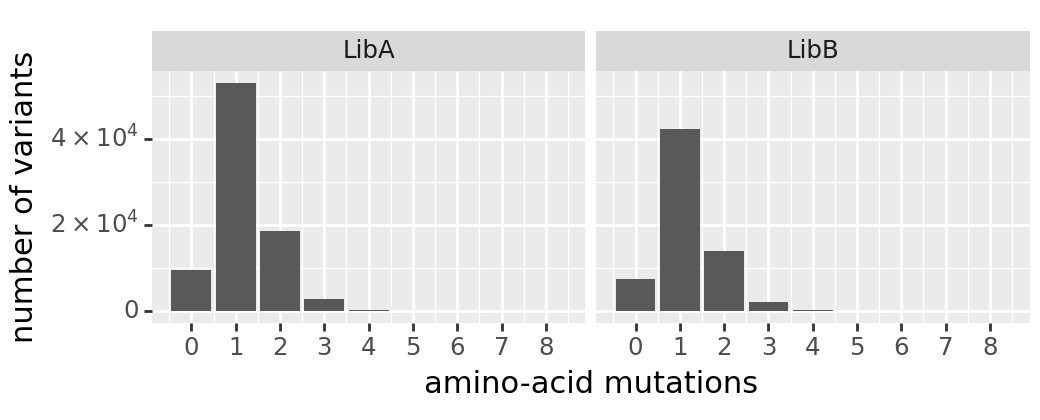

In [7]:
# distribution of amino-acid mutations per variant
p = variants.plotNumMutsHistogram(
    mut_type="aa",
    max_muts=8,
    widthscale=1.3,
    heightscale=1,
    libraries=variants.libraries,
    samples=None,
)
fig = p.draw(show=True)

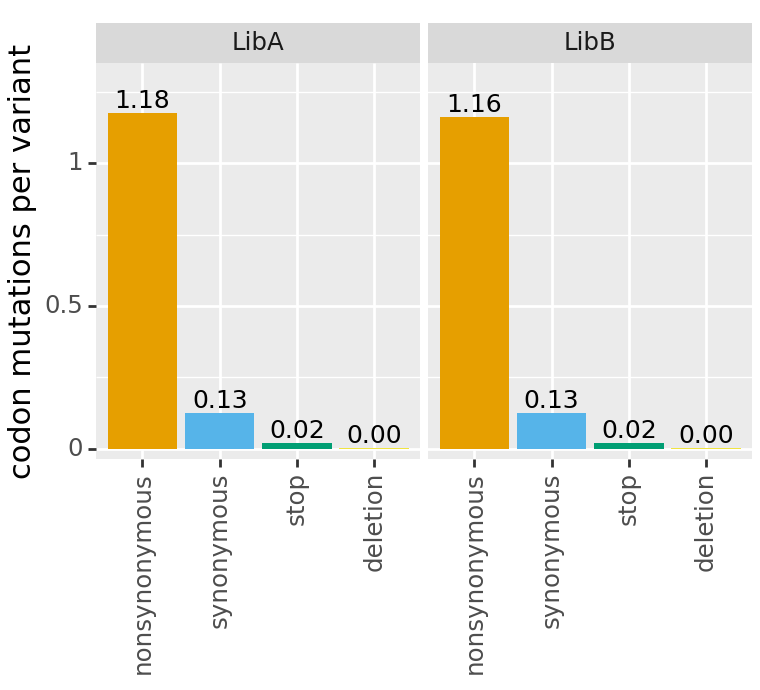

In [8]:
# average mutations per variant
p = variants.plotNumCodonMutsByType(
    variant_type="all",
    samples=None,
    libraries=variants.libraries,
    widthscale=1,
    heightscale=1.5,
    ylabel="codon mutations per variant",
)
fig = p.draw(show=True)

Also make a nice `altair` version of this plot:

In [9]:
num_muts = variants.numCodonMutsByType(
    variant_type="all",
    samples=None,
    libraries=variants.libraries,
).assign(
    # remove categorical assignments to fix plotting issues
    mutation_type=lambda x: x["mutation_type"].tolist(),
    library=lambda x: x["library"].tolist(),
)

mut_type_order = (
    num_muts.sort_values("number", ascending=False)["mutation_type"].unique().tolist()
)

num_muts_chart = (
    alt.Chart(num_muts)
    .encode(
        x=alt.X("mutation_type", title=None, scale=alt.Scale(domain=mut_type_order)),
        y=alt.Y("number", title="codon mutations per variant"),
        color=alt.Color("mutation_type", legend=None),
        facet=alt.Facet("library", title=None, columns=4),
        tooltip=["library", "mutation_type", alt.Tooltip("number", format=".2f")],
    )
    .mark_bar()
    .properties(width=alt.Step(25), height=150)
)

num_muts_chart

alt.Chart(...)

## Counts of different types of mutations in the libraries
Read the designed mutations for the library, combine with site numbering file, and remove mutations that correspond to what is already wildtype in parental sequence:

In [10]:
# read designed mutations
designed_muts_site_col = config["mutation_design_classification"]["site_col"]
designed_mutations = pd.read_csv(
    config["mutation_design_classification"]["csv"]
).rename(columns={"amino_acid": "mutant_aa"})[
    [designed_muts_site_col, "mutant_aa", "mutation_type"]
]

# list of designed mutation types in order of abundance
designed_mutation_types = (
    designed_mutations.groupby("mutation_type")
    .size()
    .sort_values(ascending=False)
    .index.tolist()
)

# read reference site numbering
site_numbering_map = pd.read_csv(config["site_numbering_map"])

# read wildtype protein
refprot = str(Bio.SeqIO.read(config["gene_sequence_protein"], "fasta").seq)
assert len(refprot) >= site_numbering_map["sequential_site"].max()
assert site_numbering_map["sequential_site"].min() >= 1

# add reference site numbering and remove wildtype to wildtype mutations
designed_mutations = (
    designed_mutations.merge(
        site_numbering_map[["sequential_site", "reference_site"]],
        on=designed_muts_site_col,
        validate="many_to_one",
    )
    .rename(columns={"mutation_type": "designed_mutation_type"})
    .assign(wildtype=lambda x: x["sequential_site"].map(lambda r: refprot[r - 1]))
    .query("wildtype != mutant_aa")
    .assign(
        sequential_mutation=lambda x: x["wildtype"]
        + x["sequential_site"].astype(str)
        + x["mutant_aa"],
        reference_mutation=lambda x: x["wildtype"]
        + x["reference_site"].astype(str)
        + x["mutant_aa"],
    )[
        [
            "sequential_site",
            "sequential_mutation",
            "reference_site",
            "reference_mutation",
            "designed_mutation_type",
        ]
    ]
)

Make an [UpSet plots](https://upsetplot.readthedocs.io/) showing the designed mutations in each category, both among the set of all designed mutations, and among the variants we actually ended up with in each library.
For the libraries, we make plots showing both the identity of the mutations (each mutation counted once no matter how many times it appears) and the composition (each mutation counted as the number of variants in which it appears):

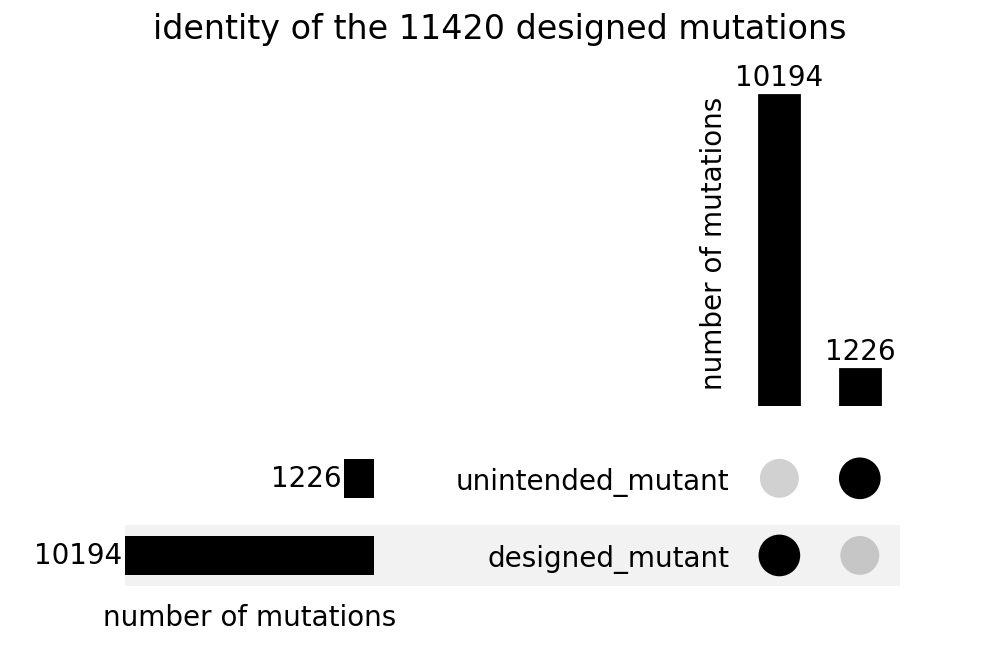

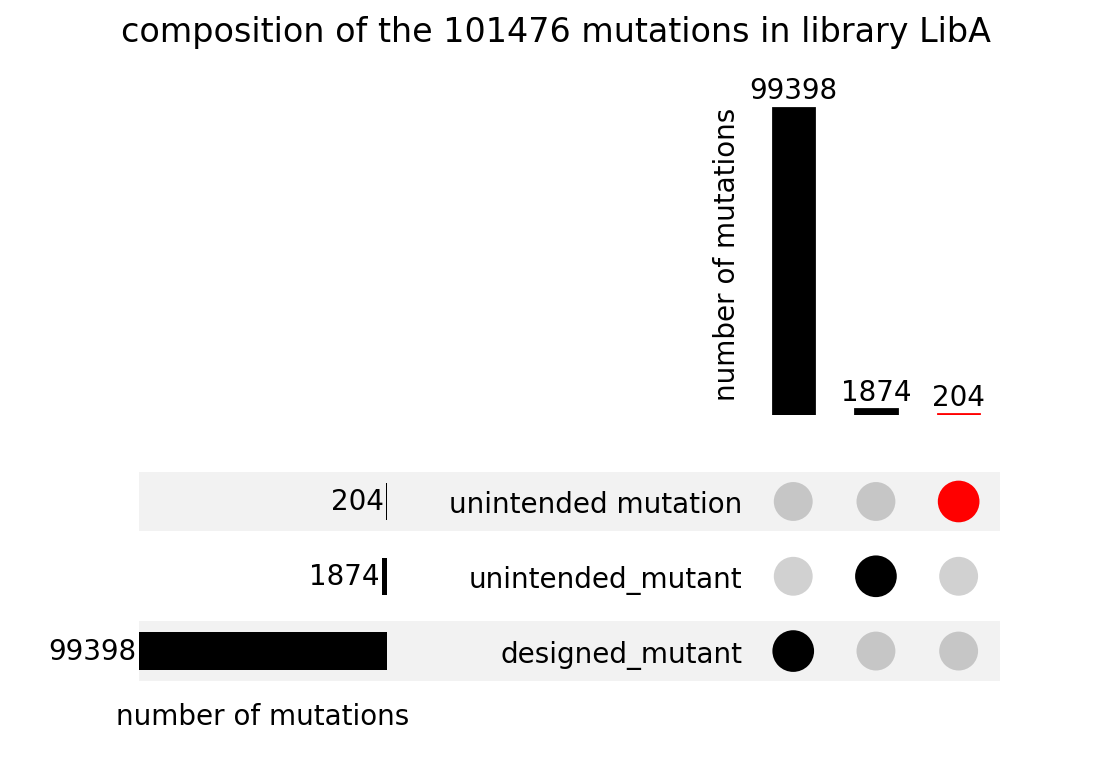

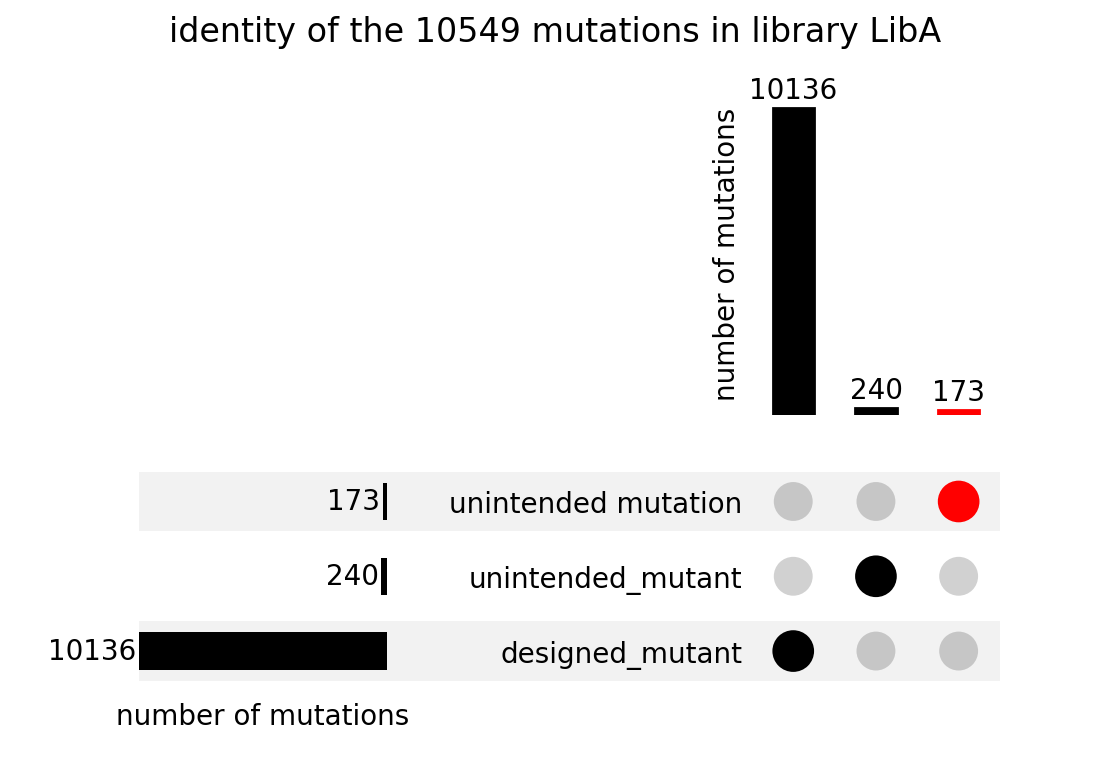

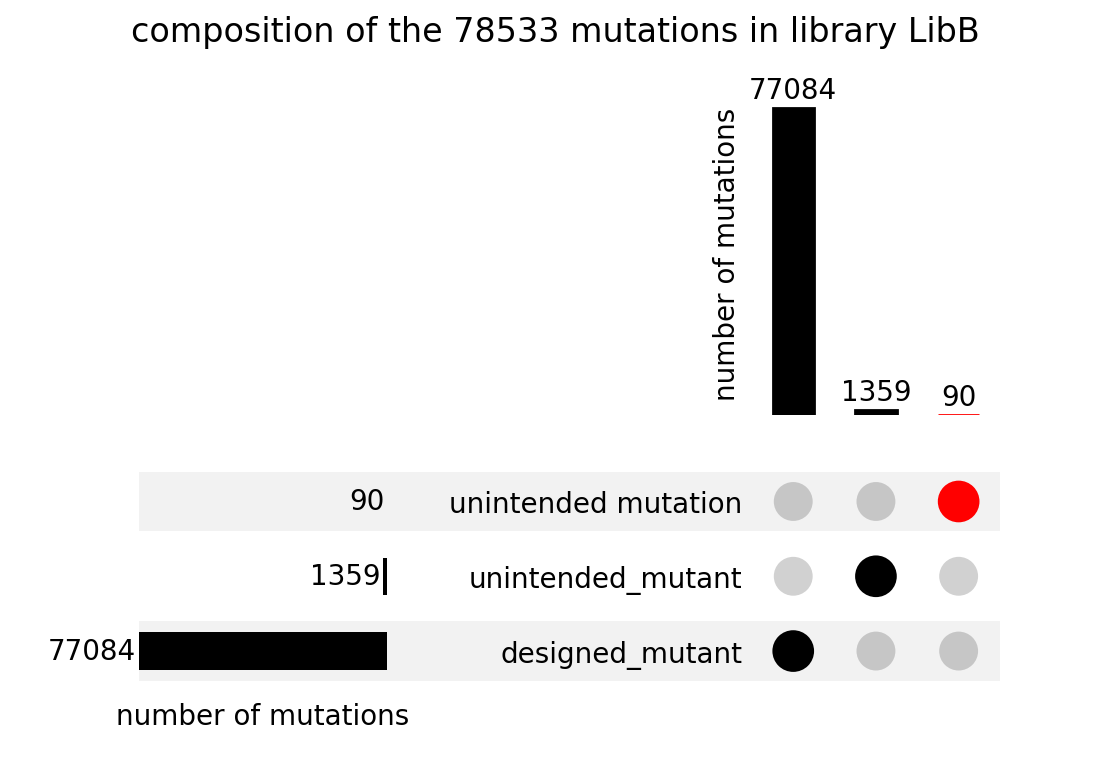

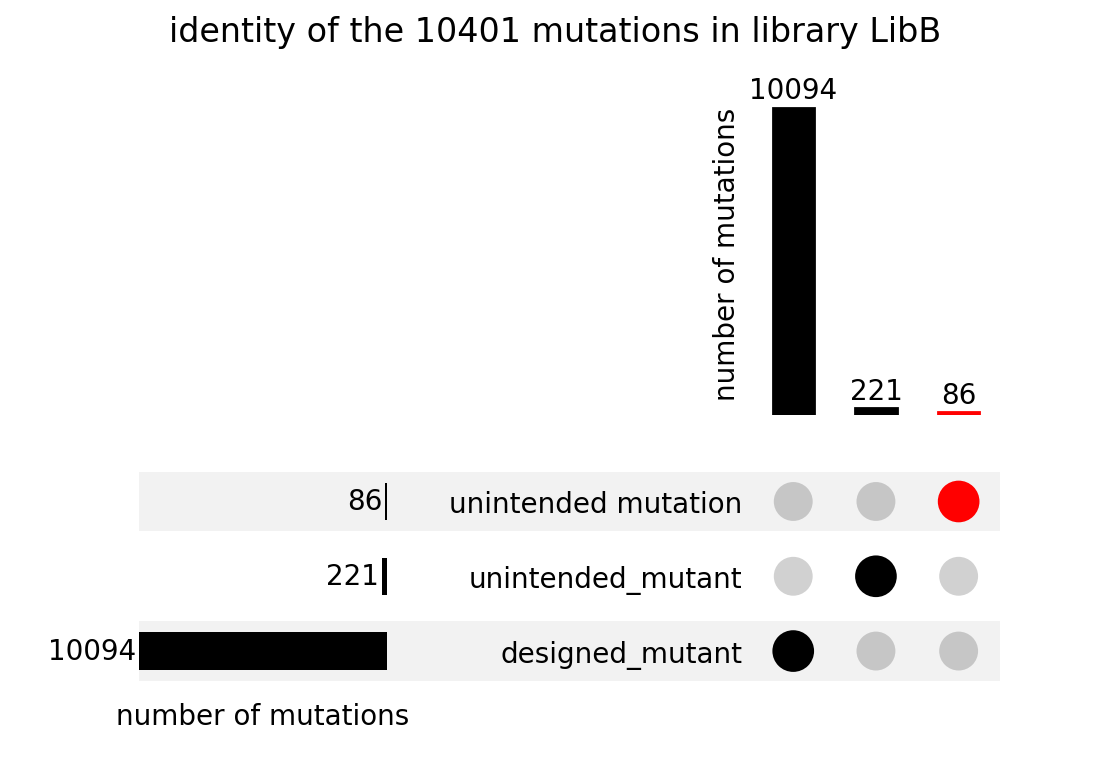

In [11]:
# first get in wide form suitable for `upsetplot` package
designed_mutations_wide = (
    designed_mutations.assign(exists=True)
    .pivot_table(
        index=["sequential_site", "sequential_mutation"],
        columns="designed_mutation_type",
        values="exists",
        fill_value=False,
        aggfunc="any",
    )
    .reset_index()
    .set_index(designed_mutation_types)
)

# make upset plot for all designed mutations and each library
for lib, weighted in itertools.product([None, *variants.libraries], [True, False]):
    if lib is None:
        df = designed_mutations_wide.assign(count=1)
        if weighted:
            continue  # weighted plot does not make sense here
    else:
        # get mutation counts among variants in library
        df = (
            variants.mutCounts(
                variant_type="all",
                mut_type="aa",
                samples=None,
                libraries=[lib],
            )
            .query("count > 0")
            .rename(columns={"mutation": "sequential_mutation"})[
                ["sequential_mutation", "count"]
            ]
            .merge(
                designed_mutations_wide["sequential_mutation"].reset_index(),
                how="left",
                on="sequential_mutation",
                validate="many_to_one",
            )
            .fillna({col: False for col in designed_mutation_types})
            .assign(
                **{
                    "unintended mutation": lambda x: (
                        ~x[designed_mutation_types].apply(pd.Series.any, axis=1)
                    )
                }
            )
            .set_index([*designed_mutation_types, "unintended mutation"])
        )
    if weighted:
        suptitle = "composition of the"
        label = "number of mutations"
    else:
        suptitle = "identity of the"
        label = "number of mutations"
        df["count"] = df["count"].clip(upper=1)

    muts_fig = plt.Figure()
    muts_plt = upsetplot.UpSet(
        data=df,
        sum_over="count",
        subset_size="sum",
        sort_by="cardinality",
        show_counts=True,
        element_size=40,
        intersection_plot_elements=4,
        totals_plot_elements=3,
    )
    if "unintended mutation" in df.index.names:
        muts_plt.style_subsets(present="unintended mutation", facecolor="red")
    muts_axes = muts_plt.plot(fig=muts_fig)
    _ = muts_axes["intersections"].set_ylabel(label)
    _ = muts_axes["intersections"].set_yticks([])
    _ = muts_axes["intersections"].spines["left"].set_visible(False)
    _ = muts_axes["intersections"].grid(visible=False)
    _ = muts_axes["totals"].set_xlabel(label)
    _ = muts_axes["totals"].set_xticks([])
    _ = muts_axes["totals"].spines["bottom"].set_visible(False)
    _ = muts_axes["totals"].grid(visible=False)
    n_mutations = df["count"].sum()
    if lib is None:
        desc = "designed mutations"
    else:
        desc = f"mutations in library {lib}"
    _ = muts_fig.suptitle(f"{suptitle} {n_mutations} {desc}")
    display(muts_fig)

## Mutation frequencies along the gene
Average frequency of mutations across all variants at each site:

In [12]:
# frequencies of mutations at each site
site_freqs = (
    variants.mutCounts(
        variant_type="all",
        mut_type="aa",
        samples=None,
        libraries=variants.libraries,
    )
    .query("count > 0")
    .rename(columns={"site": "sequential_site"})
    .merge(
        site_numbering_map,
        how="left",
        on="sequential_site",
        validate="many_to_one",
    )
    .assign(
        wildtype=lambda x: x["mutation"].str[0],
        mutant=lambda x: x["mutation"].str[-1],
        reference_site=lambda x: (
            x["reference_site"]
            if all(x["reference_site"] == x["reference_site"].astype(str))
            else x["reference_site"].astype("Int64")
        ),
        # remove categorical assignments to fix plotting issues
        library=lambda x: x["library"].tolist(),
    )
    .assign(mutant=lambda x: x["mutant"] + "=" + x["count"].astype(str))
    .sort_values("count", ascending=False)
    .groupby(
        ["library", "sequential_site", "reference_site", "wildtype"],
        observed=True,
        as_index=False,
    )
    .aggregate(
        count=pd.NamedAgg("count", "sum"),
        mutants=pd.NamedAgg("mutant", ", ".join),
    )
    .merge(
        variants.n_variants_df(
            samples=None, libraries=variants.libraries, primary_target_only=True
        )
        .rename(columns={"count": "n_variants"})
        .drop(columns="sample")
    )
    .assign(percent=lambda x: 100 * x["count"] / x["n_variants"])
    .drop(columns="n_variants")
)

In [13]:
# make chart
zoom_brush = alt.selection_interval(
    encodings=["x"],
    mark=alt.BrushConfig(stroke="black", strokeWidth=2),
)

zoom_bar = (
    alt.Chart(site_freqs[["sequential_site"]].drop_duplicates())
    .mark_rect(color="lightgrey")
    .encode(
        x=alt.X("sequential_site", title=None, scale=alt.Scale(nice=False, zero=False))
    )
    .add_params(zoom_brush)
    .properties(width=550, height=15, title="site zoom bar")
)

site_freqs_base = (
    alt.Chart()
    .encode(
        x=alt.X(
            "reference_site",
            scale=alt.Scale(nice=False, zero=False),
            sort=alt.SortField("sequential_site"),
        ),
        y=alt.Y("percent", title="% variants with mutation"),
        tooltip=[
            alt.Tooltip(c, format=".3g")
            if c in {"percent", "count", "n_variants"}
            else c
            for c in site_freqs.columns
        ],
    )
    .properties(height=125, width=550)
)

site_freqs_chart = (
    alt.layer(
        site_freqs_base.mark_point(filled=True),
        site_freqs_base.mark_line(size=0.5),
        data=site_freqs,
    )
    .facet(facet=alt.Facet("library", title=None), columns=1)
    .add_params(zoom_brush)
    .transform_filter(zoom_brush)
)

site_freqs_zoom_chart = (zoom_bar & site_freqs_chart).configure_axis(grid=False)

site_freqs_zoom_chart

alt.VConcatChart(...)

## How many variants have each mutation?
We categorize mutations by the design categories into which they fall.
Only include mutations that are either observed or designed:

In [14]:
# get ranked counts of each mutation designed in libraries
# first get counts
mut_counts_designed = (
    variants.mutCounts(
        variant_type="all",
        mut_type="aa",
        samples=None,
        libraries=variants.libraries,
    )
    .rename(columns={"mutation": "sequential_mutation", "site": "sequential_site"})
    .merge(
        designed_mutations,
        how="outer",
        on=["sequential_mutation", "sequential_site"],
        validate="many_to_many",
    )
    .drop(columns=["reference_site", "sample"])
    .assign(
        designed_mutation_type=lambda x: x["designed_mutation_type"].fillna(
            "unintended mutation"
        ),
        # remove categorical assignments to fix plotting issues
        library=lambda x: x["library"].tolist(),
        mutation_type=lambda x: x["mutation_type"].tolist(),
    )
    .merge(
        site_numbering_map[["sequential_site", "reference_site"]],
        on="sequential_site",
        validate="many_to_one",
    )
    .assign(
        reference_mutation=lambda x: x["sequential_mutation"].str[0]
        + x["reference_site"].astype(str)
        + x["sequential_mutation"].str[-1]
    )
    .drop(columns=["sequential_site", "reference_site"])
    .query("(count > 0) | (designed_mutation_type != 'unintended mutation')")
)

# add ranks
mut_counts_designed = mut_counts_designed.merge(
    mut_counts_designed[["library", "sequential_mutation", "count"]]
    .drop_duplicates()
    .assign(
        rank=lambda x: (
            x.groupby("library")["count"]
            .transform("rank", method="first", ascending=False)
            .astype(int)
        )
    ),
    on=["library", "sequential_mutation", "count"],
    how="left",
    validate="many_to_one",
)

Plot number of variants with each mutation.
The legend is clickable, and you can click on entries to just show those categories (or shift-click for multiple selections).
You can also use the scroll wheel on the mouse to zoom the x-axis:

In [15]:
# now plot ranked counts

designed_mutation_type_selection = alt.selection_point(
    fields=["designed_mutation_type"],
    bind="legend",
)

mutation_type_selection = alt.selection_point(
    fields=["mutation_type"],
    bind="legend",
)

coverage_chart = (
    alt.Chart(mut_counts_designed)
    .encode(
        x=alt.X(
            "rank",
            title="mutation rank",
            scale=alt.Scale(
                nice=False, padding=5, domain=[1, mut_counts_designed["rank"].max()]
            ),
        ),
        y=alt.Y(
            "count",
            title="number of variants",
            scale=alt.Scale(
                nice=False, padding=5, domain=[0, mut_counts_designed["count"].max()]
            ),
        ),
        color=alt.Color(
            "designed_mutation_type",
            title="designed mutation type",
            scale=alt.Scale(
                domain=mut_counts_designed["designed_mutation_type"].unique(),
            ),
        ),
        shape=alt.Shape(
            "mutation_type",
            title="mutation type",
            scale=alt.Scale(
                domain=mut_counts_designed["mutation_type"].unique().tolist(),
            ),
        ),
        facet=alt.Facet(
            "library",
            title=None,
            columns=2,
        ),
        tooltip=mut_counts_designed.columns.tolist(),
    )
    .mark_point(filled=True)
    .properties(height=170, width=290)
    .add_params(designed_mutation_type_selection, mutation_type_selection)
    .transform_filter(designed_mutation_type_selection)
    .transform_filter(mutation_type_selection)
    .interactive(bind_x=True, bind_y=False)
)

coverage_chart

alt.Chart(...)

## Write codon-variant tables
Write the codon-variant tables to CSV files:

In [16]:
print(f"Writing codon variants to {config['codon_variants']}")
variants.barcode_variant_df.to_csv(config["codon_variants"], index=False)

Writing codon variants to results/variants/codon_variants.csv
